In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
import joblib

from sklearn.model_selection import train_test_split

RANDOM_STATE = 42


In [4]:
df = pd.read_csv('../data/processed/fraud_processed.csv')

df = df.dropna(subset=['class'])
df['class'] = df['class'].astype(int)

X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


C:\Users\betteyk\AppData\Local\Temp\ipykernel_68168\863708940.py:1: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/fraud_processed.csv')


In [5]:
best_model = joblib.load('../models/best_model.joblib')

# THIS LINE IS CRITICAL
best_model.fit(X_train, y_train)


d:\KAIM\weak-5\fraud-detection\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:59:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [6]:
preprocessor = best_model.named_steps['preprocessor']
classifier = best_model.named_steps['classifier']


In [7]:
X_test_transformed = preprocessor.transform(X_test)


In [9]:
print("Categorical columns:", preprocessor.transformers_[1][2])


Categorical columns: []


In [10]:
# Numeric feature names
num_features = preprocessor.transformers_[0][2]

# Handle categorical features safely
cat_cols = preprocessor.transformers_[1][2]

if len(cat_cols) == 0:
    # No categorical features
    feature_names = np.array(num_features)
else:
    ohe = preprocessor.transformers_[1][1].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([num_features, cat_features])

print("Number of features:", len(feature_names))
print("Transformed shape:", X_test_transformed.shape)


Number of features: 11
Transformed shape: (25830, 11)


In [11]:
importances = pd.Series(
    classifier.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

# Show top 10
importances.head(10)

time_since_signup         0.147780
day_of_week               0.143932
hour_of_day               0.143451
lower_bound_ip_address    0.143167
purchase_value            0.141603
user_id                   0.140366
age                       0.139701
upper_bound_ip_address    0.000000
user_transaction_count    0.000000
time_since_last_txn       0.000000
dtype: float32

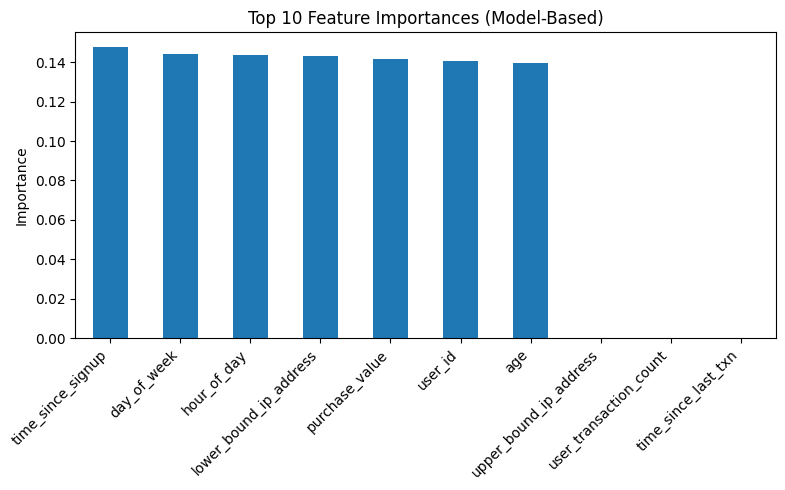

In [12]:
plt.figure(figsize=(8, 5))
importances.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances (Model-Based)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
#Create SHAP explainer

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test_transformed)


In [16]:
type(shap_values), np.array(shap_values).shape


(numpy.ndarray, (25830, 11))

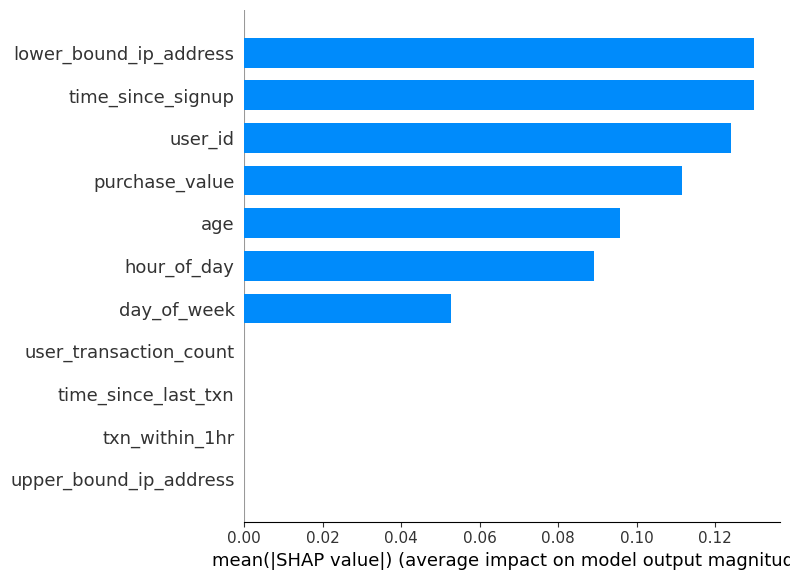

In [18]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar"
)


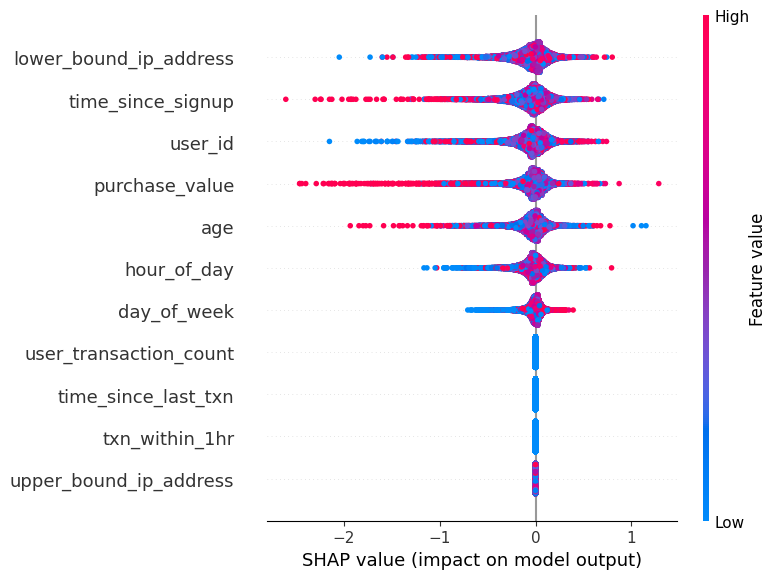

In [19]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names
)


SHAP vs. Feature Importance:
The SHAP summary plot confirms that behavioral and temporal features dominate fraud predictions. Features such as time_since_signup, purchase_value, and transaction timing show wide SHAP value distributions, indicating strong and consistent influence. This aligns well with the model’s built-in feature importance, validating model reliability.

Top 5 Drivers of Fraud Predictions:

time_since_signup – Very short time since signup strongly increases fraud risk.

purchase_value – Higher purchase values tend to push predictions toward fraud, especially when combined with other risk factors.

lower_bound_ip_address / IP-related features – Certain IP ranges are associated with elevated fraud likelihood.

hour_of_day – Transactions at unusual hours increase fraud probability.

user_id / activity-related behavior – Irregular user behavior patterns influence fraud detection.

Surprising Findings:
High purchase value alone does not always result in fraud classification. SHAP shows that contextual factors—such as longer account history or normal transaction timing—can offset risk. Additionally, some low-value transactions are flagged due to abnormal timing or IP-related patterns, highlighting that fraud is behavior-driven rather than value-driven.



Business Recommendations (SHAP-Driven)

Early Account Protection:
Apply additional verification for transactions occurring soon after signup, as time_since_signup is a strong fraud driver.

Context-Aware Transaction Review:
Avoid blocking transactions based solely on amount; combine purchase_value with behavioral and temporal signals to reduce false positives.

Time & IP-Based Risk Scoring:
Increase monitoring for transactions occurring at unusual hours or from higher-risk IP ranges, as SHAP indicates these features significantly impact fraud predictions.